<a href="https://colab.research.google.com/github/KaraNoSora/SE207_WI22_Course_Materials/blob/main/Lab8_DD_PINN/SE_207_Computer_Assignment_7_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem -- PINN
---

Consider a one-way wave equation in 1D

\begin{equation}
    \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0,\ t\in(0, 6]\ {\rm and}\ x \in (-5, 5) 
\end{equation}

where $c=0.5$ is a constant for wave velocity. The initial condition of this problem is 

\begin{equation}
    u(x, 0) = \cos x + \sin 0.5x
\end{equation}

The analytical solution for this problem is

\begin{equation}
    u(x, t) = \cos (x - ct) + \sin 0.5(x - ct)
\end{equation}

In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt

global mseloss
mseloss = torch.nn.MSELoss()

Below is a block creating the measured data. We assume there are fictitious oscillation records of $u(x, t)$ at $x = -4.8, -2.5, 0, 2.5,\ {\rm and}\ 4.8\ (0<t\leq 6)$.

In [79]:
# We assume these 50 values are from measurements.
def create_u():
    t_his = torch.linspace(0, 6, 120, requires_grad=True)
    t_base = torch.zeros(120, 1)
    t_base[:, 0] = t_his.clone()
    t_m = torch.cat((t_base, t_base, t_base, t_base, t_base), axis=0)

    one_vec = torch.ones_like(t_base, requires_grad=True)
    x_m = torch.cat((-4.8 * one_vec, -2.5 * one_vec, 0.0 * one_vec, 2.5 * one_vec, 4.8 * one_vec), axis=0)

    u = torch.cos(x_m.detach() - 0.5 * t_m.detach()) + torch.sin(0.5 * (x_m.detach() - 0.5 * t_m.detach()))
    return u, torch.cat((x_m, t_m), dim=1)

Use the record and PINN to infer the wave function $u(x, t)$.

**a)** Write down the loss function for this PINN problem.

**Hints**: you need to sample a set of spatial coordinates $\{x\}$ for the initial condition.

**b)** We assume $c = 0.5$. Do the following

1. Write an ANN that you think is sufficient for this problem. You can tune the number of layers and neurons based on the training history.

In [85]:
# complete this part
class PINN(torch.nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = torch.nn.Linear(in_features=2, out_features=30)
        self.fc2 = torch.nn.Linear(in_features=30, out_features=1)
        self.act = torch.nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        return out

Below is the class for the wave equation, you do not have to change it.

In [86]:
#@title Dataset of Points
class Wave_dataset(object):
    
    def __init__(self, n_col, n_ic):
        
        # The number of collocation points
        self.n_col = n_col
        # The number of sampled initial points
        self.n_ic = n_ic

        # collocation points
        # uniformly sample x in (-5, 5)
        self.x_c = 10 * torch.rand(n_col, 1, requires_grad=True) - 5
        # uniformly sample t in (0, 6)
        self.t_c = 6 * torch.rand(n_col, 1, requires_grad=True)

        # initial points
        self.x_i = 10 * torch.rand(self.n_ic, 1, requires_grad=True) - 5
        self.t_i = torch.zeros_like(self.x_i, requires_grad=False)

        # concatenate the spatial and time variables together: 
        # Column 1: x, Column 2: t
        self.Xc = torch.cat((self.x_c, self.t_c), dim=1)
        self.Xi = torch.cat((self.x_i, self.t_i), dim=1)

        # zero source term
        self.f = torch.zeros(self.Xc.shape[0], 1)

        # initial condition evaulations for reference
        self.Ui = torch.cos(self.x_i.detach()) + torch.sin(0.5 * self.x_i.detach())

        # measured points
        self.Um, self.Xm = create_u()

2. Complete the PINN loss function below.

In [87]:
def pinn_loss(model, dset, mse=mseloss):
    
    #Complete this function to return the total cost
    u_pred    = model(dset.Xc)       # predicted u at collocation points
    u_pred_ic = model(dset.Xi)       # predicted u for the initial points (t = 0)
    u_pred_m  = model(dset.Xm)       # predicted u at measured points

    grad_u = torch.autograd.grad(u_pred, dset.Xc, grad_outputs=torch.ones_like(u_pred), create_graph=True)
    
    # a vector of the LHS of the PDE dudt + 0.5du/dx
    lhs = torch.add(grad_u[0][:, 1:2], 0.5*grad_u[0][:, 0:1])

    # MSE of the PDE residual
    MSEf = mse(lhs, dset.f)  
    
    # MSE of the initial condition                        
    MSEb = mse(u_pred_ic, torch.cos(dset.Xi[:,0:1].detach()) + torch.sin(0.5*dset.Xi[:,0:1].detach()))
    
    # MSE of the measured u
    MSEu = mse(dset.Um, u_pred_m)
    
    loss = MSEf + 5*MSEb +  MSEu
    
    return loss

In [93]:
#@title train_pinn()

def train_pinn(model, dset, epochs=2000):
    train_losses = np.empty([epochs, 1])
    min_loss = 1e4

    criterion = pinn_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 50:
            if epoch % 100 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.9

        # train for one epoch
        loss = pinn_loss(model, dset)
        train_losses[epoch] = loss.detach().numpy()

        if loss < min_loss:
            best_model = model
            min_loss = loss.clone()

        if epoch % 200 == 0:
            print('Epoch: %d -- Loss: %.5f' %(epoch, loss))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
    train_losses.tofile('train_loss' + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(train_losses)
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE')
    ax.title.set_text('Training loss')
    ax.set_yscale('log')
    return best_model

3. Train the PINN using the code block below. To get a good result, you may change your network's architecture or set the learning rate decay manually (the code in the Lab 8 notebook shows how to manually set the learning rate).  

Epoch: 0 -- Loss: 8.51625
Epoch: 200 -- Loss: 0.01453
Epoch: 400 -- Loss: 0.00322
Epoch: 600 -- Loss: 0.00255
Epoch: 800 -- Loss: 0.00213
Epoch: 1000 -- Loss: 0.00187
Epoch: 1200 -- Loss: 0.00172
Epoch: 1400 -- Loss: 0.00159
Epoch: 1600 -- Loss: 0.00149
Epoch: 1800 -- Loss: 0.00140
Epoch: 2000 -- Loss: 0.00132
Epoch: 2200 -- Loss: 0.00125
Epoch: 2400 -- Loss: 0.00120
Epoch: 2600 -- Loss: 0.00114
Epoch: 2800 -- Loss: 0.00110
Epoch: 3000 -- Loss: 0.00106
Epoch: 3200 -- Loss: 0.00102
Epoch: 3400 -- Loss: 0.00099
Epoch: 3600 -- Loss: 0.00096
Epoch: 3800 -- Loss: 0.00093
Epoch: 4000 -- Loss: 0.00091
Epoch: 4200 -- Loss: 0.00089
Epoch: 4400 -- Loss: 0.00087
Epoch: 4600 -- Loss: 0.00086
Epoch: 4800 -- Loss: 0.00084


PINN(
  (fc1): Linear(in_features=2, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
  (act): Tanh()
)

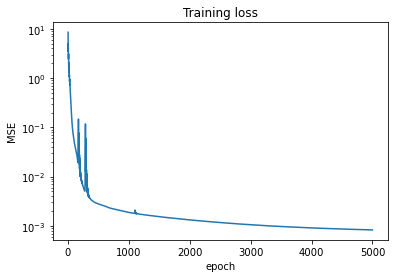

In [97]:
pinnset = Wave_dataset(n_col=8000, n_ic=500)
model = PINN()
train_pinn(model, pinnset, epochs=5000)

**c)** Plot the analytical soluton $u(x, t)$ and PINN solution $\hat{u}(x, t)$ vs $x$ at $t = 0$, $t = 1$, and $t = 2.5$, and $t = 6$.

In [98]:
tp = np.arange(0, 6, 0.1)
xp = np.arange(-5, 5, 0.1)
T, X = np.meshgrid(tp, xp)
Z = np.ndarray([len(xp), len(tp)])
E = np.ndarray([len(xp), len(tp)])

for idx in range(len(xp)):
    for idy in range(len(tp)):
        inp = torch.tensor([X[idx, idy], T[idx, idy]], dtype=torch.float)
        Z[idx, idy] = model(inp)

Text(0, 0.5, '$u$')

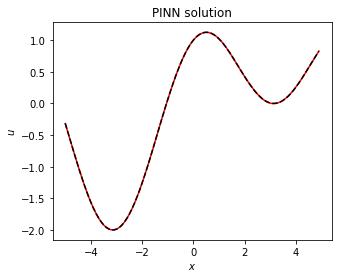

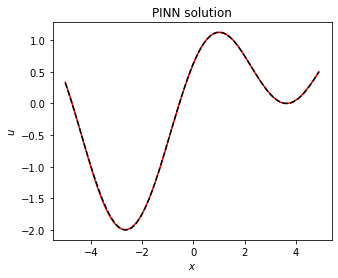

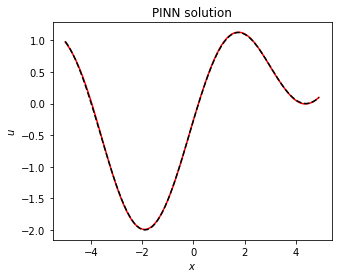

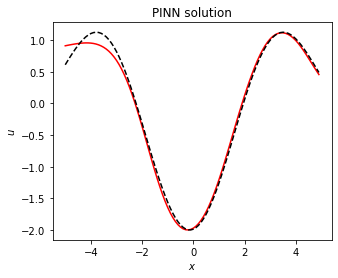

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cp1 = plt.plot(X[:,int(0/0.01)], Z[:,int(0/0.01)], 'r-')
cp2 = plt.plot(X[:,0], np.cos(X[:,0] - 0.5*0) + np.sin(0.5*(X[:,0]-0.5*0)) , 'k--')
ax.set_title('PINN solution')
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cp1 = plt.plot(X[:,int(1/0.1)], Z[:,int(1/0.1)], 'r-')
cp2 = plt.plot(X[:,0], np.cos(X[:,0] - 0.5*1) + np.sin(0.5*(X[:,0]-0.5*1)) , 'k--')
# ax.scatter(x_record[0, :], x_record[1, :], linewidths=0.07)
ax.set_title('PINN solution')
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cp1 = plt.plot(X[:,int(2.5/0.1)], Z[:,int(2.5/0.1)], 'r-')
cp2 = plt.plot(X[:,0], np.cos(X[:,0] - 0.5*2.5) + np.sin(0.5*(X[:,0]-0.5*2.5)) , 'k--')
# ax.scatter(x_record[0, :], x_record[1, :], linewidths=0.07)
ax.set_title('PINN solution')
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
cp1 = plt.plot(X[:,int(6/0.1)-1], Z[:,int(6/0.1)-1], 'r-')
cp2 = plt.plot(X[:,0], np.cos(X[:,0] - 0.5*6) + np.sin(0.5*(X[:,0]-0.5*6)) , 'k--')
# ax.scatter(x_record[0, :], x_record[1, :], linewidths=0.07)
ax.set_title('PINN solution')
ax.set_xlabel('$x$')
ax.set_ylabel('$u$')

# # ax.legend()
# plt.show()